## Routing Problem - Exercise 1

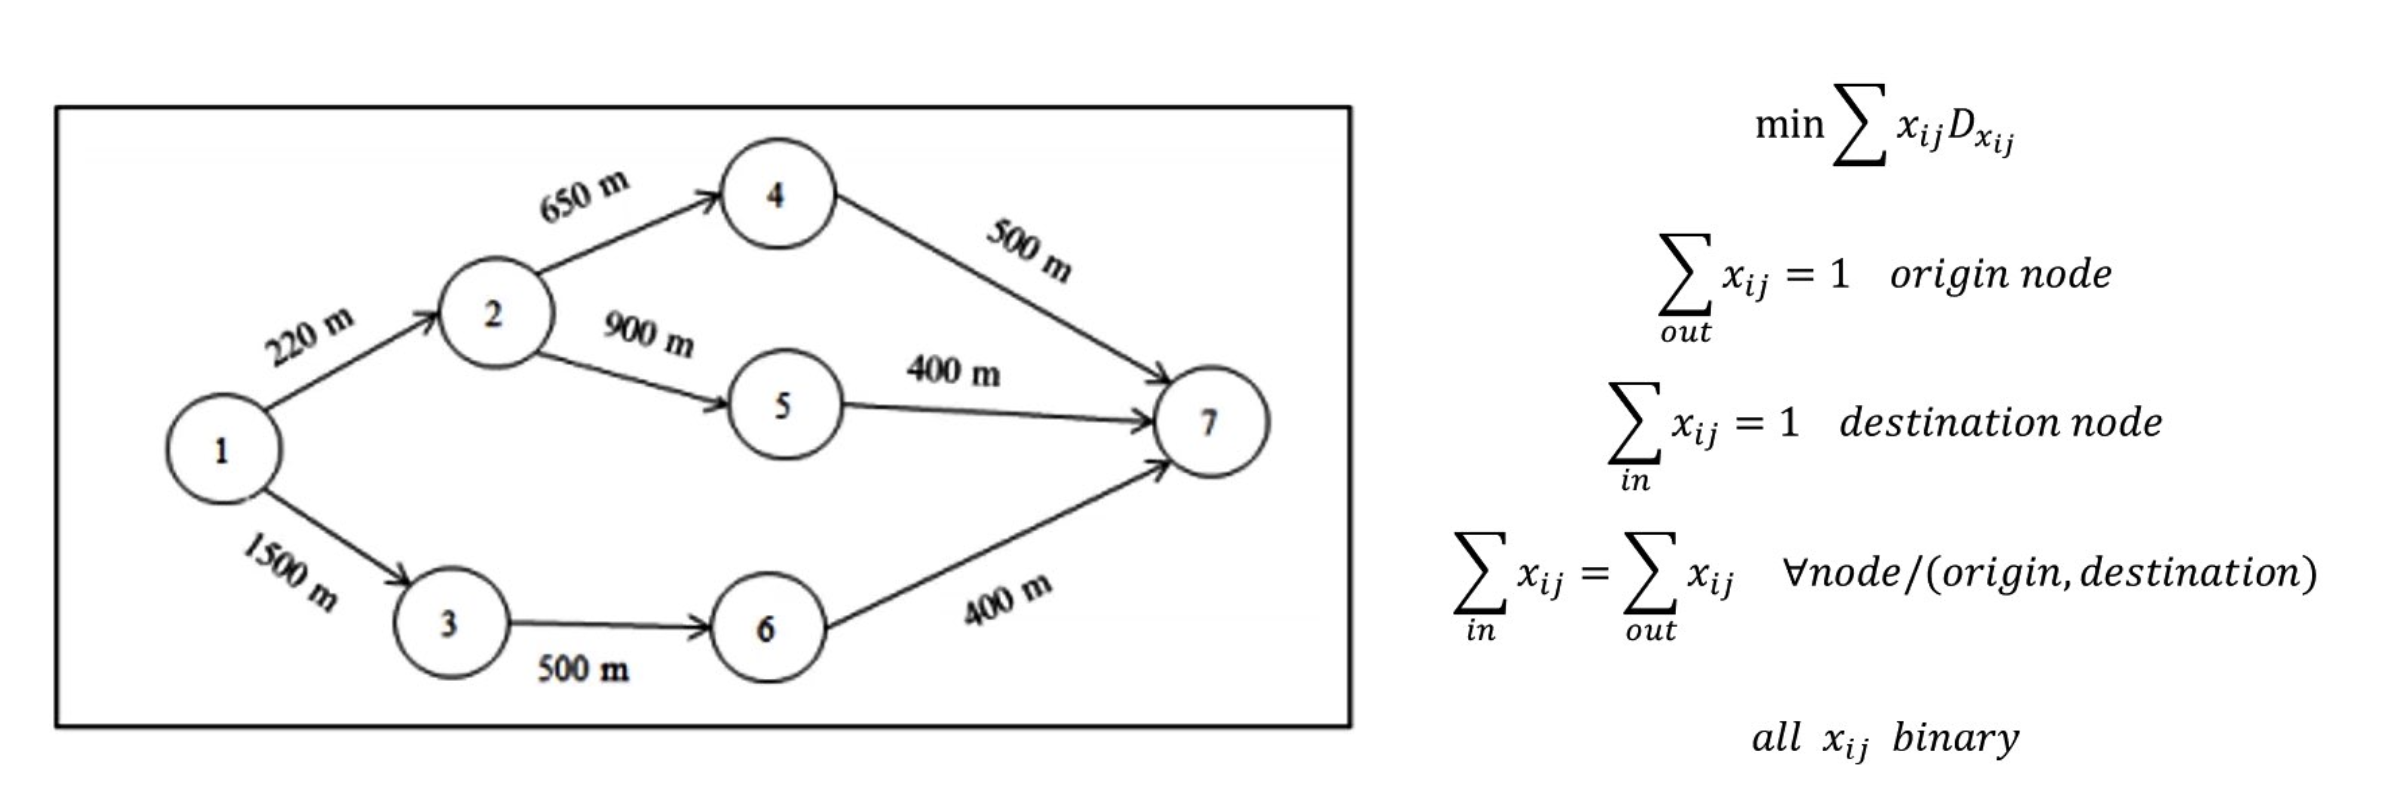

In [1]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

m = pyo.ConcreteModel()

#sets of points
m.setAllPoints = ['1','2','3','4','5', '6', '7']
m.setPoints = ['2','3','4', '5', '6']

#sets of routes from to
m.setRoutes = [['1','2'],['1','3'],['2','4'],['2','5'],['3','6'],['4','7'],['5','7'], ['6','7']]
m.setRoutes_from = {key:[] for key in m.setAllPoints}
m.setRoutes_to = {key:[] for key in m.setAllPoints}
for route in m.setRoutes:
    m.setRoutes_from[route[0]].append(route[1])
    m.setRoutes_to[route[1]].append(route[0])

#parameters
m.D = {}
m.D['1','2'] = 220
m.D['1','3'] = 1500
m.D['2','4'] = 650
m.D['2','5'] = 900
m.D['3','6'] = 500
m.D['4','7'] = 500
m.D['5','7'] = 400
m.D['6','7'] = 400

#variables
m.x = pyo.Var(m.setRoutes, within=pyo.Binary)

#objective function
m.obj = pyo.Objective(expr = sum([
    m.x[route[0], route[1]] * m.D[route[0], route[1]]
    for route in m.setRoutes
    ]), sense=pyo.minimize)

#constraints --> TIP: run the code and print m.setRoutes_from and m.setRoutes_to, and check the SETs of the problem
#you can replace m.setRoutes_from['A'] for 'P1', 'P2'], it would work for this problem, but not for a other network
m.C1 = pyo.Constraint(expr = sum([m.x['1',j] for j in m.setRoutes_from['1']]) == 1)
m.C2 = pyo.Constraint(expr = sum([m.x[i,'7'] for i in m.setRoutes_to['7']]) == 1)
m.C3 = pyo.ConstraintList()
for i in m.setPoints:
    m.C3.add(sum([m.x[i,j] for j in m.setRoutes_from[i]]) == sum([m.x[j,i] for j in m.setRoutes_to[i]]))

#solve
opt = SolverFactory('cbc')
m.results = opt.solve(m)

#print
m.pprint()
print('\n\nOF:',pyo.value(m.obj))
for route in m.setRoutes:
    if pyo.value(m.x[route[0], route[1]]) >= 0.9:
        print('Route activated: %s-%s' % (route[0], route[1]))

2 Set Declarations
    C3_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    8 : {('1', '2'), ('1', '3'), ('2', '4'), ('2', '5'), ('3', '6'), ('4', '7'), ('5', '7'), ('6', '7')}

1 Var Declarations
    x : Size=8, Index=x_index
        Key        : Lower : Value : Upper : Fixed : Stale : Domain
        ('1', '2') :     0 :   1.0 :     1 : False : False : Binary
        ('1', '3') :     0 :   0.0 :     1 : False : False : Binary
        ('2', '4') :     0 :   1.0 :     1 : False : False : Binary
        ('2', '5') :     0 :   0.0 :     1 : False : False : Binary
        ('3', '6') :     0 :   0.0 :     1 : False : False : Binary
        ('4', '7') :     0 :   1.0 :     1 : False : False : Binary
        ('5', '7') :     0 :   0.0 :     1 : False : False : Bina

In [2]:
import pandas as pd, numpy as np
from ortools.sat.python import cp_model

#inputs
nodes = pd.read_excel('/Users/jamin/Desktop/Learning/Operations Research/Udemy Course/Optimization with Python - Solve Operations Research Problems/14 - More exercises and modeling/005 route-inputs.xlsx', sheet_name='nodes')
paths = pd.read_excel('/Users/jamin/Desktop/Learning/Operations Research/Udemy Course/Optimization with Python - Solve Operations Research Problems/14 - More exercises and modeling/005 route-inputs.xlsx', sheet_name='paths')
n_nodes = len(nodes)
n_paths = len(paths)

#model
model = cp_model.CpModel()
x = np.zeros(n_paths).tolist()
for p in paths.index:
    x[p] = model.NewIntVar(0,1,'x[{}]'.format([p]))

#objective function
objFun = sum([x[p] * paths.distance[p] for p in paths.index])
model.Minimize(objFun)

#constraint sum(x) == 1 (origin and destination)
node_origin = int(nodes.node[nodes.description=='origin'])
node_destination = int(nodes.node[nodes.description=='destination'])
model.Add(sum([x[p] for p in paths.index[paths.node_from==node_origin]]) == 1)
model.Add(sum([x[p] for p in paths.index[paths.node_to==node_destination]]) == 1)

#constraint sum(x, in) == sum(x, out)
for node in nodes.node[nodes.description=='middle point']:
    sum_in = sum([x[p] for p in paths.index[paths.node_to==node]])
    sum_out = sum([x[p] for p in paths.index[paths.node_from==node]])
    model.Add(sum_in == sum_out)
    
#solve
solver = cp_model.CpSolver()
status = solver.Solve(model)

#print
print('status =', solver.StatusName(status))
print('OF =', solver.ObjectiveValue())

paths['activated'] = 0
for p in paths.index:
    paths.activated[p] = solver.Value(x[p])
print(paths)

status = OPTIMAL
OF = 1370.0
   node_from  node_to  distance  activated
0          1        2       220          1
1          1        3      1500          0
2          2        4       650          1
3          2        5       900          0
4          4        7       500          1
5          5        7       400          0
6          3        6       500          0
7          6        7       400          0


/var/folders/p_/4x45bbsx2wj3jn7vzxg3z6d80000gn/T/ipykernel_5102/87924649.py:21: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  node_origin = int(nodes.node[nodes.description=='origin'])
/var/folders/p_/4x45bbsx2wj3jn7vzxg3z6d80000gn/T/ipykernel_5102/87924649.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  node_destination = int(nodes.node[nodes.description=='destination'])


## Routing Problem - Exercise 2

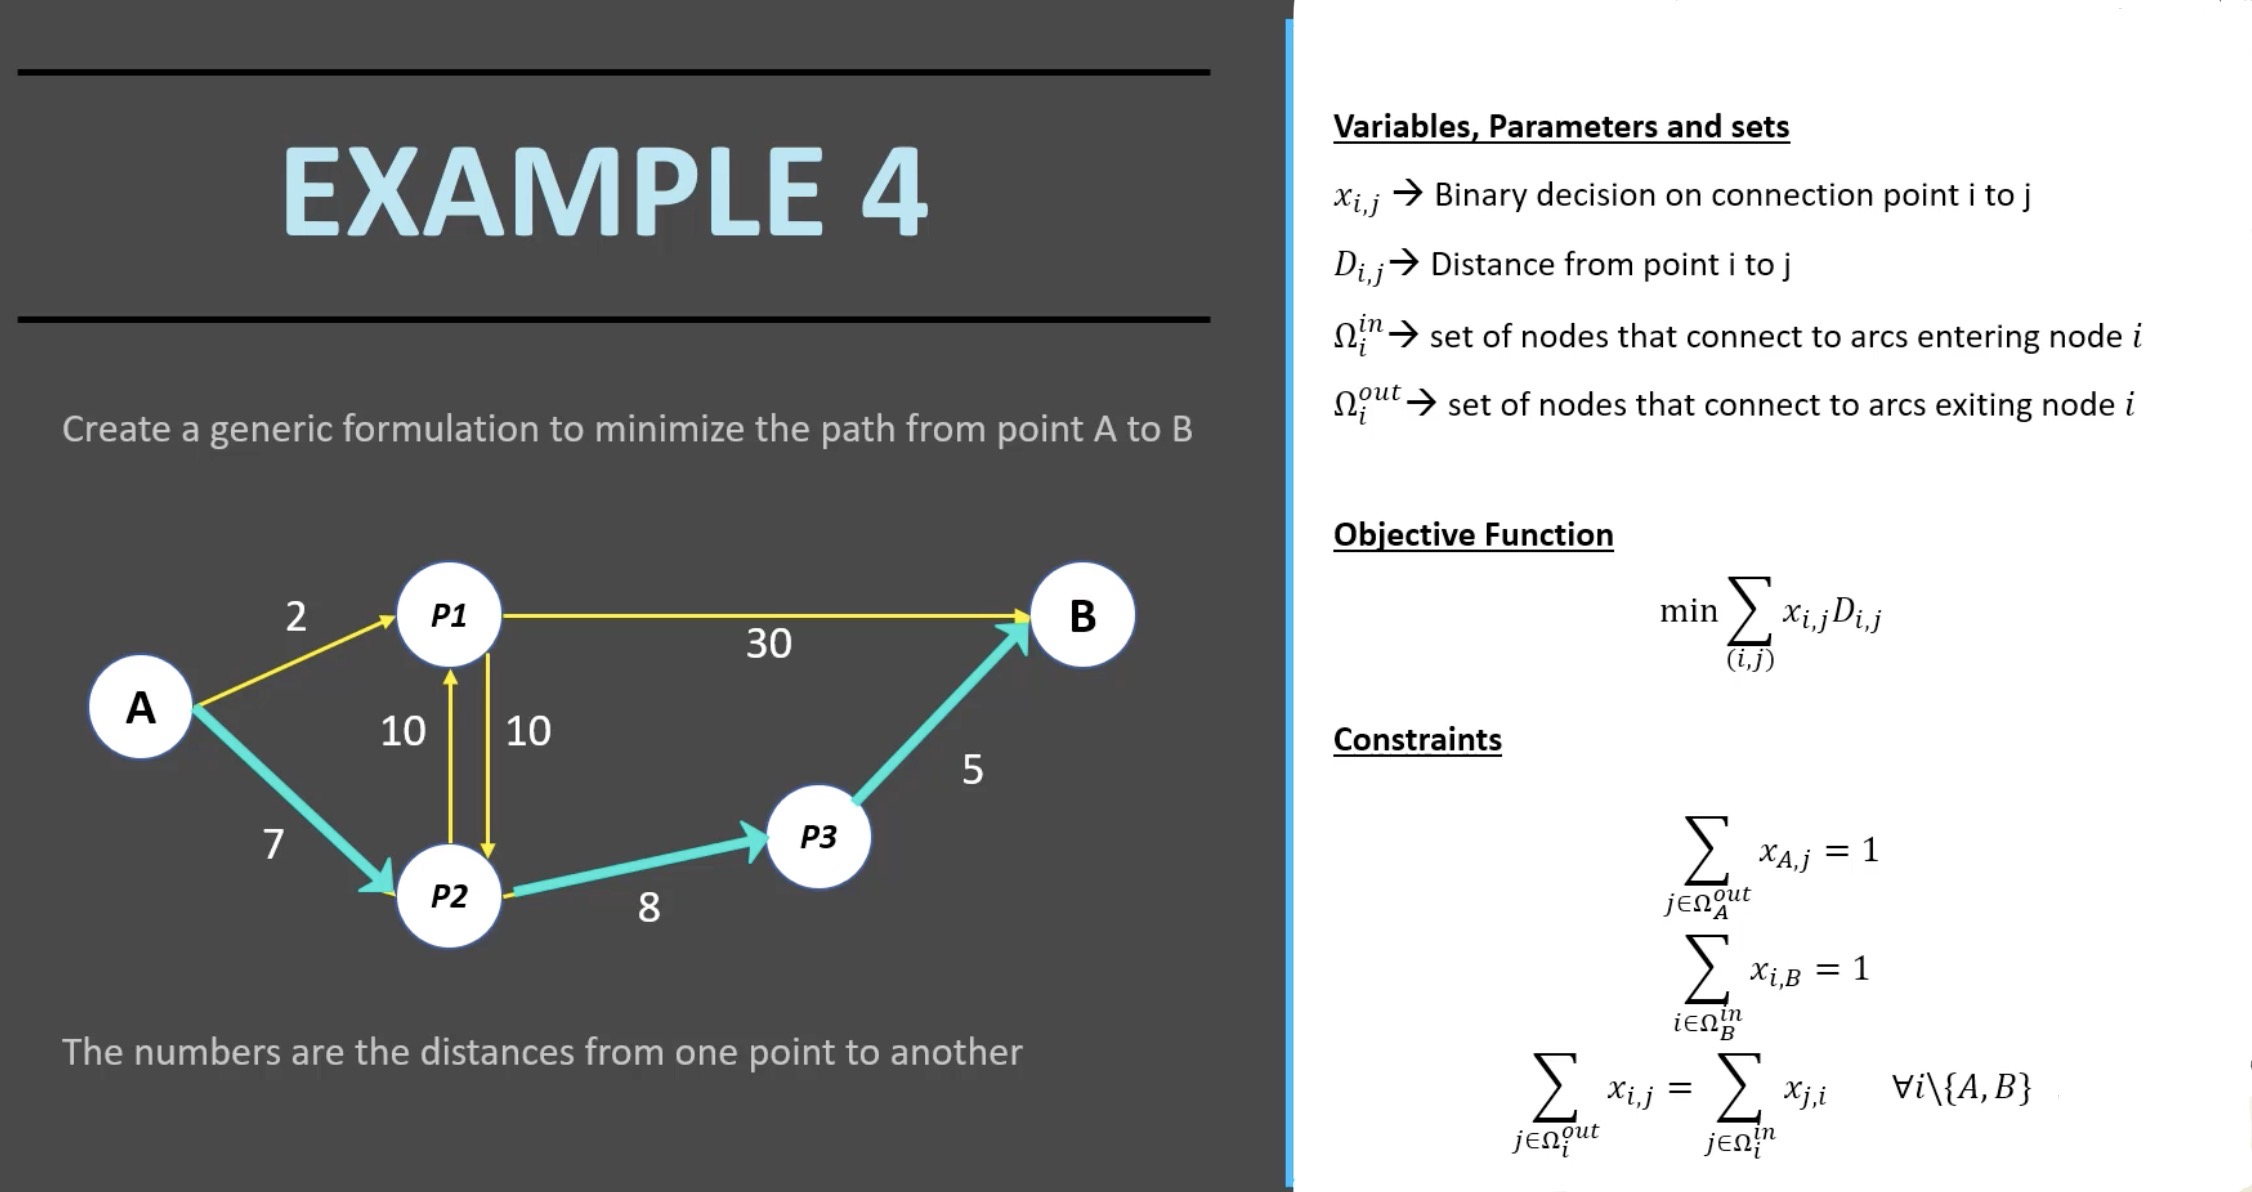

In [3]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

m = pyo.ConcreteModel()

#sets of points
m.setAllPoints = ['A','P1','P2','P3','B']
m.setPoints = ['P1','P2','P3']

#sets of routes from to
m.setRoutes = [['A','P1'],['A','P2'],['P1','P2'],['P2','P1'],['P1','B'],['P2','P3'],['P3','B']]
m.setRoutes_from = {key:[] for key in m.setAllPoints}
# m.setRoutes_from = {'A': [], 'P1': [], 'P2': [], 'P3': [], 'B': []}

m.setRoutes_to = {key:[] for key in m.setAllPoints}
# m.setRoutes_to = {'A': [], 'P1': [], 'P2': [], 'P3': [], 'B': []}


In [4]:
m.setRoutes_from

{'A': [], 'P1': [], 'P2': [], 'P3': [], 'B': []}

In [5]:
for route in m.setRoutes:
    m.setRoutes_from[route[0]].append(route[1])
    m.setRoutes_to[route[1]].append(route[0])
    
print("m.setRoutes_from is:", m.setRoutes_from)
print("m.setRoutes_to is:" ,m.setRoutes_to)

m.setRoutes_from is: {'A': ['P1', 'P2'], 'P1': ['P2', 'B'], 'P2': ['P1', 'P3'], 'P3': ['B'], 'B': []}
m.setRoutes_to is: {'A': [], 'P1': ['A', 'P2'], 'P2': ['A', 'P1'], 'P3': ['P2'], 'B': ['P1', 'P3']}


In [6]:
#parameters
m.D = {}
m.D['A','P1'] = 2 
m.D['A','P2'] = 7 
m.D['P1','P2'] = 10 
m.D['P2','P1'] = 10 
m.D['P1','B'] = 30 
m.D['P2','P3'] = 8 
m.D['P3','B'] = 5 

#variables
m.x = pyo.Var(m.setRoutes, within=pyo.Binary)

#objective function
m.obj = pyo.Objective(expr = sum([m.x[route[0], route[1]] * m.D[route[0], route[1]] for route in m.setRoutes]), sense=pyo.minimize)

#constraints --> TIP: run the code and print m.setRoutes_from and m.setRoutes_to, and check the SETs of the problem
#you can replace m.setRoutes_from['A'] for 'P1', 'P2'], it would work for this problem, but not for a other network
m.C1 = pyo.Constraint(expr = sum([m.x['A',j] for j in m.setRoutes_from['A']]) == 1)
m.C2 = pyo.Constraint(expr = sum([m.x[i,'B'] for i in m.setRoutes_to['B']]) == 1)
m.C3 = pyo.ConstraintList()
for i in m.setPoints:
    m.C3.add(sum([m.x[i,j] for j in m.setRoutes_from[i]]) == sum([m.x[j,i] for j in m.setRoutes_to[i]]))
    

In [7]:
print(f"The distance between each node is: {m.D}")

The distance between each node is: {('A', 'P1'): 2, ('A', 'P2'): 7, ('P1', 'P2'): 10, ('P2', 'P1'): 10, ('P1', 'B'): 30, ('P2', 'P3'): 8, ('P3', 'B'): 5}


### Solve the problem and print the optimal routing path

In [8]:
#solve
opt = SolverFactory('cbc')
m.results = opt.solve(m)

#print
m.pprint()
print('\n\nOF:',pyo.value(m.obj))
for route in m.setRoutes:
    if pyo.value(m.x[route[0], route[1]]) >= 0.9:
        print('Route activated: %s-%s' % (route[0], route[1]))

2 Set Declarations
    C3_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {1, 2, 3}
    x_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    7 : {('A', 'P1'), ('A', 'P2'), ('P1', 'P2'), ('P2', 'P1'), ('P1', 'B'), ('P2', 'P3'), ('P3', 'B')}

1 Var Declarations
    x : Size=7, Index=x_index
        Key          : Lower : Value : Upper : Fixed : Stale : Domain
         ('A', 'P1') :     0 :   0.0 :     1 : False : False : Binary
         ('A', 'P2') :     0 :   1.0 :     1 : False : False : Binary
         ('P1', 'B') :     0 :   0.0 :     1 : False : False : Binary
        ('P1', 'P2') :     0 :   0.0 :     1 : False : False : Binary
        ('P2', 'P1') :     0 :   0.0 :     1 : False : False : Binary
        ('P2', 'P3') :     0 :   1.0 :     1 : False : False : Binary
         ('P3', 'B') :     0 :   1.0 :     1 : False : Fals